In [28]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [98]:
input_hcp_dwi='/scratch/TESTS/fix_HCP_dwi/input_sample/100307/nrrd/data_corrected.nrrd'
input_hcp_t1='/scratch/TESTS/fix_HCP_dwi/input_sample/100307/T1w_acpc_dc_restore_1.25.nii.gz'
input_hcp_brainmask='/scratch/TESTS/fix_HCP_dwi/input_sample/100307/nrrd/nodif_brain_mask.nrrd'

OutputDir='/scratch/TESTS/superResolution/HCP/outImageFiles'
MatlabFilesDir='/scratch/TESTS/superResolution/HCP/matlabFiles'

In [30]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
#PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release_20150715/bin'
PROGRAM_PATHS = '/scratch/BS/release-BSR/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from nipype.interfaces.ants import DenoiseImage
from nipype.interfaces.semtools import *

In [31]:
# 
# READ input DWI scan using pynrrd
#
import nrrd

class nrrdDWIHeader:
    """A helper class for manipulating header information
    from a nrrd DWI data set into a nibabel compliant
    format"""
    def __init__(self,pynrrdDataModel):
        self.modality=None                      #Matches NRRD File
        self.global_BValue=None                 #Matches NRRD File
        self.gradientUnormalizedVectors=[None]  #Matches NRRD File

        self.gradientIndex=-1
        self.gradientBValues=[None]             #Computed
        self.gradientVectors=[None]             #Computed
        self._ConvertNrrdToNibabelDWIDataModel(pynrrdDataModel)

    def Print(self):
        print("global_BValue {0}".format(self.global_BValue) )
        print("modality {0}".format(self.modality) )
        print("gradientBValues {0}".format(self.gradientBValues) )
        print("gradientDirections {0}".format(self.gradientUnormalizedVectors) )

    def _getGradientStorageIndex(self,pynrrdDataModel):
        """The 4D index that has separate gradients.
        all other directions are the spatial dimensions."""
        gradient_index=-1;
        centerings=pynrrdDataModel['centerings']
        numdwidims=len(centerings)
        for test_index in range(0,numdwidims):
            if centerings[test_index] not in ['cell']:
                gradient_index=test_index
        self.gradientIndex = gradient_index

    def _ExtractGlobalBValue(self, pyNrrdKVUnknownMetaData):
        globalBValueString=pyNrrdKVUnknownMetaData.get(u'DWMRI_b-value','0').lstrip().rstrip()
        self.global_BValue=float( globalBValueString )

    def _ExtractUnormalizedBValues(self,pyNrrdKVUnknownMetaData,pynrrdDataModel):
        """Unnormalized data values from the nrrd files, where the
        magnitude is reflective of the scale relative to the global_BValue"""
        self._getGradientStorageIndex(pynrrdDataModel)
        numGradients = pynrrdDataModel[u'sizes'][self.gradientIndex]
        self.gradientUnormalizedVectors= np.array( [ [ None, None, None ] for x in range(0,numGradients) ] )
        gvec_Fields=pyNrrdKVUnknownMetaData.copy() #Clone so we can remove items
        for k,v in gvec_Fields.iteritems():
            if k.startswith("DWMRI_gradient_"):
                index=int(k.split('_')[2])
                self.gradientUnormalizedVectors[index,:]=np.array([ float(x) for x in v.rstrip().lstrip().split() ],
                                                    copy=True, order='C', ndmin=1)
                pyNrrdKVUnknownMetaData.pop(k)


    def _ExtractDWIModality(self,pyNrrdKVUnknownMetaData):
        self.modality=pyNrrdKVUnknownMetaData.get("modality","UNKNOWN").lstrip().rstrip()

    def _ComputeNormalizedBvecBVals(self,pyNrrdKVUnknownMetaData,pynrrdDataModel):
        self._ExtractGlobalBValue(pyNrrdKVUnknownMetaData)
        self._ExtractUnormalizedBValues(pyNrrdKVUnknownMetaData,pynrrdDataModel)
        self._ComputeNormalizedGradientsAndBValues()

    def _ComputeNormalizedGradientsAndBValues(self):
        """Following conventions of NRRD format, expand
        to normalized vectors and estimate BValues
        :return: void
        """
        numGradients=len( self.gradientUnormalizedVectors )

        self.gradientVectors = np.array(self.gradientUnormalizedVectors)
        self.gradientBValues = np.array( [ self.global_BValue ] * numGradients )
        for index in range(0,numGradients):
            gv = self.gradientUnormalizedVectors[index]
            norm=np.linalg.norm(gv)
            if norm < 1e-2:
                self.gradientVectors[index] = gv * 0.0
                self.gradientBValues[index] = 0.0
            elif ( abs( 1.0-norm ) > 1e-4 ): # Avoid rescaling if norm is almost one
                self.gradientVectors[index] = gv/norm
                b_i = self.global_BValue * (norm**2) # norm = sqrt(b_i/b_max)
                self.gradientBValues[index] = float("{0:.1f}".format(b_i))

    def _ConvertNrrdToNibabelDWIDataModel(self, pynrrdDataModel):
        pyNrrdKVUnknownMetaData=pynrrdDataModel['keyvaluepairs']
        self._ExtractDWIModality(pyNrrdKVUnknownMetaData)
        self._ExtractGlobalBValue(pyNrrdKVUnknownMetaData)
        self._ComputeNormalizedBvecBVals(pyNrrdKVUnknownMetaData,pynrrdDataModel)

def ReadNAMICDWIFromNrrd(filename):
    nrrd_dwi_data,nrrd_dwi_header=nrrd.read(filename)
    nibabelDataModelDWI=nrrdDWIHeader(nrrd_dwi_header)
    nrrd_dwi_bvec=nibabelDataModelDWI.gradientVectors
    nrrd_dwi_bval=nibabelDataModelDWI.gradientBValues
    gradient_index=nibabelDataModelDWI.gradientIndex
    return (nrrd_dwi_data, nrrd_dwi_header, nrrd_dwi_bvec, nrrd_dwi_bval, gradient_index)

# Create edge map image from T1

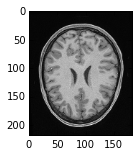

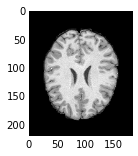

In [35]:
t1 = sitk.ReadImage(input_hcp_t1)
myshow(t1)

brainmask = sitk.ReadImage(input_hcp_brainmask)
maskf = sitk.Cast(brainmask, sitk.sitkFloat32)

t1_brain = sitk.Multiply(t1,maskf)
myshow(t1_brain)
sitk.WriteImage(t1_brain,os.path.join(OutputDir,'T1_brain.nrrd'))

In [36]:
mgi_fn = os.path.join(OutputDir,'mgi.nrrd') # Maximum gradient image
BRIANSToolsPath = "/scratch/BS/release-BSR/bin"

!{BRIANSToolsPath}/BRAINSSuperResolution \
--inputMRVolumes {os.path.join(OutputDir,'T1_brain.nrrd')} \
--outputEdgeMap {mgi_fn}

Reading image: /scratch/TESTS/superResolution/HCP/outImageFiles/T1_brain.nrrd
Generating maximum gradient edgemap took 0.297486 s.
Reading DWI image: 
ERROR:  Could not read image .


106.0
1.0


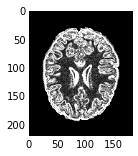

In [44]:
mgi = sitk.ReadImage(mgi_fn)

totalStats = sitk.StatisticsImageFilter()
totalStats.Execute(mgi)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

myshow(mgi)

1.0
0.00943396240473


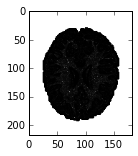

In [45]:
# "edgeMask" is computed as 1/mgi
#----------------------------------------------
# compute 1/mgi
mgi = sitk.Cast(mgi,sitk.sitkFloat32)

div = sitk.DivideImageFilter()
edgeMask = div.Execute(1.0,mgi)
myshow(edgeMask)

totalStats = sitk.StatisticsImageFilter()
totalStats.Execute(edgeMask)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

sitk.WriteImage(edgeMask,os.path.join(OutputDir,'edgemask.nrrd'))

In [46]:
edge_arr = sitk.GetArrayFromImage(edgeMask)

import scipy.io
scipy.io.savemat(os.path.join(MatlabFilesDir,'edgemask.mat'), mdict={'edgemask': edge_arr})

# Extract dwi_b0 image

In [99]:
dwi_data,dwi_header,bvecs,bvals,gradient_index1 = ReadNAMICDWIFromNrrd(input_hcp_dwi)

In [137]:
print(gradient_index1)

0


In [138]:
print(dwi_data.shape)
print(dwi_data.shape[gradient_index1])

(145, 174, 145, 288)
145


Note that above data array is converted from Nifit format (itkVectorImage), so it is pixel interleaved (compared to volume interleaved), and the gradient index is the first index.

However, if we had read the image directly from Nifti version using nibabel, the data shape would have volume interleaved format.

img = nib.load(DWI_nifti_fn)

data = img.get_data()

print(data.shape)

(145, 174, 145, 288)

Since dipy needs the data array in volume interleaved format, we need to do permutaion on data array.

In [101]:
dwi_data = np.transpose(dwi_data,(1, 2, 3, 0))
print(dwi_data.shape)

(145, 174, 145, 288)


In [127]:
# Now extract b0 component of the 4D DWI array
dwi_b0 = dwi_data[:,:,:,0]
print(dwi_b0.shape)

(145, 174, 145)


To convert the above numpy array to a b0 image, we need careful attention to the order of index and dimensions.

ITK's Image class does not have a bracket operator. It has a GetPixel which takes an ITK Index object as an argument, which is an array ordered as (x,y,z). This is the convention that SimpleITK's Image class uses for the GetPixel method as well.

While in numpy, an array is indexed in the opposite order (z,y,x).

In [128]:
dwi_b0 = np.transpose(dwi_b0,(2, 1, 0))

In [134]:
'''
print(dwi_b0.dtype)
print(dwi_b0.shape)
print(np.amax(dwi_b0))
print(np.amin(dwi_b0))
print(np.mean(dwi_b0))
'''

'\nprint(dwi_b0.dtype)\nprint(dwi_b0.shape)\nprint(np.amax(dwi_b0))\nprint(np.amin(dwi_b0))\nprint(np.mean(dwi_b0))\n'

In [130]:
# Normalize array between zero and one
def NormalizeBetweenZeroAndOne(arr):   
    newMax = 1.0
    newMin = 0.0
    #
    oldMax = float(np.amax(arr))
    oldMin = float(np.amin(arr))
    #
    f=(newMax-newMin)/(oldMax-oldMin)
    normalized_arr = (arr-oldMin)*f+newMin
    return normalized_arr

dwi_b0_normalized = NormalizeBetweenZeroAndOne(dwi_b0)

In [135]:
'''
print(dwi_b0_normalized.dtype)
print(dwi_b0_normalized.shape)
print(np.amax(dwi_b0_normalized))
print(np.amin(dwi_b0_normalized))
print(np.mean(dwi_b0_normalized))
'''

'\nprint(dwi_b0_normalized.dtype)\nprint(dwi_b0_normalized.shape)\nprint(np.amax(dwi_b0_normalized))\nprint(np.amin(dwi_b0_normalized))\nprint(np.mean(dwi_b0_normalized))\n'

In [136]:
# Write the normalized array to a matlab file
#
scipy.io.savemat(os.path.join(MatlabFilesDir,'dwi_b0.mat'), mdict={'inputImage': dwi_b0_normalized})

Note that if you want to write the extracted b0 image to disk, you need to get correct "origin", "spacing" and "direction cosign" from the input DWI data.

In [118]:
# Show b0 image
'''
# First read input DWI to get direction and origin
in_dwi = sitk.ReadImage(input_hcp_dwi)

dwi_b0_img = sitk.GetImageFromArray(dwi_b0)
dwi_b0_img.SetOrigin(in_dwi.GetOrigin())
dwi_b0_img.SetDirection(in_dwi.GetDirection())
dwi_b0_img.SetSpacing(in_dwi.GetSpacing())

print(dwi_b0_img.GetSize())
myshow(dwi_b0_img)
sitk.WriteImage(dwi_b0_img,os.path.join(OutputDir,'dwi_b0.nrrd'))
'''

"\n# First read input DWI to get direction and origin\nin_dwi = sitk.ReadImage(input_hcp_dwi)\n\ndwi_b0_img = sitk.GetImageFromArray(dwi_b0)\ndwi_b0_img.SetOrigin(in_dwi.GetOrigin())\ndwi_b0_img.SetDirection(in_dwi.GetDirection())\ndwi_b0_img.SetSpacing(in_dwi.GetSpacing())\n\nprint(dwi_b0_img.GetSize())\nmyshow(dwi_b0_img)\nsitk.WriteImage(dwi_b0_img,os.path.join(OutputDir,'dwi_b0.nrrd'))\n"

Also, note that after permutation of dwi_data, now dipy can be used to create the correct tensor model for DWI data. Following runs a test and shows the FA image.

This step is not needed for the purpose of this ticket; however, it will be needed when we are going to compute distance images from the HCP baseline data and the reconstructed images.

In [119]:
# Compute tensorfit
'''
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

from dipy.reconst.dti import TensorModel
ten = TensorModel(gtab)
tenfit = ten.fit(dwi_data)
'''

'\nfrom dipy.core.gradients import gradient_table\ngtab = gradient_table(bvals, bvecs)\n\nfrom dipy.reconst.dti import TensorModel\nten = TensorModel(gtab)\ntenfit = ten.fit(dwi_data)\n'

In [120]:
# Show FA image
'''
fa = tenfit.fa
fa = np.transpose(fa,(2, 1, 0)) # the reason is inconsistency between index order in numpy and ITK

FA = sitk.GetImageFromArray(fa)
FA.SetOrigin(in_dwi.GetOrigin())
FA.SetDirection(in_dwi.GetDirection())
FA.SetSpacing(in_dwi.GetSpacing())

maskf64 = sitk.Cast(brainmask, sitk.sitkFloat64)
FA = sitk.Multiply(FA,maskf64)

myshow(FA)
sitk.WriteImage(FA,os.path.join(OutputDir,'FA.nrrd'))
'''

"\nfa = tenfit.fa\nfa = np.transpose(fa,(2, 1, 0)) # the reason is inconsistency between index order in numpy and ITK\n\nFA = sitk.GetImageFromArray(fa)\nFA.SetOrigin(in_dwi.GetOrigin())\nFA.SetDirection(in_dwi.GetDirection())\nFA.SetSpacing(in_dwi.GetSpacing())\n\nmaskf64 = sitk.Cast(brainmask, sitk.sitkFloat64)\nFA = sitk.Multiply(FA,maskf64)\n\nmyshow(FA)\nsitk.WriteImage(FA,os.path.join(OutputDir,'FA.nrrd'))\n"

# Run 3D SuperResolution from Matlab on Each component